(scipy-image-processing)=

# Geometrical transformations on images

{mod}`scipy.ndimage` provides manipulation of n-dimensional arrays as
images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Changing orientation, resolution, ..

In [2]:
import scipy as sp

In [3]:
# Load an image
face = sp.datasets.face(gray=True)

In [4]:
# Shift, rotate and zoom it
shifted_face = sp.ndimage.shift(face, (50, 50))
shifted_face2 = sp.ndimage.shift(face, (50, 50), mode='nearest')
rotated_face = sp.ndimage.rotate(face, 30)
cropped_face = face[50:-50, 50:-50]
zoomed_face = sp.ndimage.zoom(face, 2)
zoomed_face.shape

(1536, 2048)

<Figure size 1500x300 with 0 Axes>

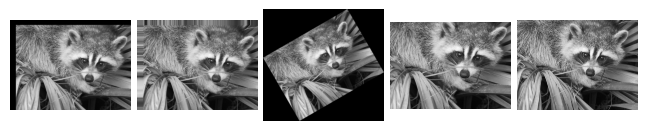

In [5]:
plt.figure(figsize=(15, 3))
fig, axes = plt.subplots(1, 5)
for i, arr in enumerate([shifted_face,
                         shifted_face2,
                         rotated_face,
                         cropped_face,
                         zoomed_face]):
    axes[i].imshow(arr, cmap="gray")
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.05, left=0.01, bottom=0.01, right=0.99, top=0.99);

## Image filtering

Generate a noisy face:

In [6]:
face = sp.datasets.face(gray=True)
face = face[:512, -512:]  # crop out square on right
noisy_face = np.copy(face).astype(float)
rng = np.random.default_rng()
noisy_face += face.std() * 0.5 * rng.standard_normal(face.shape)

Apply a variety of filters on it:

In [7]:
blurred_face = sp.ndimage.gaussian_filter(noisy_face, sigma=3)
median_face = sp.ndimage.median_filter(noisy_face, size=5)
wiener_face = sp.signal.wiener(noisy_face, (5, 5))

<Figure size 1200x350 with 0 Axes>

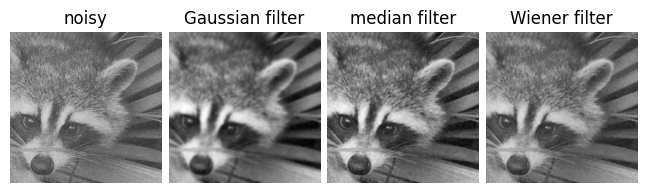

In [8]:
plt.figure(figsize=(12, 3.5))
fig, axes = plt.subplots(1, 4)
for i, (arr, name) in enumerate([[noisy_face, 'noisy'],
                                 [blurred_face, 'Gaussian filter'],
                                 [median_face, 'median filter'],
                                 [wiener_face, 'Wiener filter']]):
    axes[i].imshow(arr, cmap="gray")
    axes[i].set_title(name)
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.05, left=0.01, bottom=0.01, right=0.99, top=0.99)

Other filters in {mod}`scipy.ndimage.filters` and {mod}`scipy.signal`
can be applied to images.

::: {exercise-start}
:label: compare-histograms
:class: dropdown
:::

Compare histograms for the different filtered images.

::: {exercise-end}
:::

## Mathematical morphology

::: {note}
:class: dropdown

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) stems from set
theory. It characterizes and transforms geometrical structures. Binary
(black and white) images, in particular, can be transformed using this
theory: the sets to be transformed are the sets of neighboring
non-zero-valued pixels. The theory was also extended to gray-valued
images.
:::

![](morpho_mat.png)

Mathematical-morphology operations use a _structuring element_
in order to modify geometrical structures.

Let us first generate a structuring element:

In [9]:
el = sp.ndimage.generate_binary_structure(2, 1)
el

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

In [10]:
el.astype(int)

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]])

- **Erosion** {func}`scipy.ndimage.binary_erosion`

In [11]:
a = np.zeros((7, 7), dtype=int)
a[1:6, 2:5] = 1
a

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [12]:
sp.ndimage.binary_erosion(a).astype(a.dtype)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [13]:
# Erosion removes objects smaller than the structure
sp.ndimage.binary_erosion(a, structure=np.ones((5,5))).astype(a.dtype)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

- **Dilation** {func}`scipy.ndimage.binary_dilation`

In [14]:
a = np.zeros((5, 5))
a[2, 2] = 1
a

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [15]:
sp.ndimage.binary_dilation(a).astype(a.dtype)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

- **Opening** {func}`scipy.ndimage.binary_opening`

In [16]:
a = np.zeros((5, 5), dtype=int)
a[1:4, 1:4] = 1
a[4, 4] = 1
a

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 1]])

In [17]:
# Opening removes small objects
sp.ndimage.binary_opening(a, structure=np.ones((3, 3))).astype(int)

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])

In [18]:
# Opening can also smooth corners
sp.ndimage.binary_opening(a).astype(int)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]])

- **Closing:** {func}`scipy.ndimage.binary_closing`

::: {exercise-start}
:label: closing-exercise
:class: dropdown
:::

Check that opening amounts to eroding, then dilating.

::: {exercise-end}
:::

An opening operation removes small structures, while a closing operation
fills small holes. Such operations can therefore be used to "clean" an
image.

In [19]:
a = np.zeros((50, 50))
a[10:-10, 10:-10] = 1
rng = np.random.default_rng()
a += 0.25 * rng.standard_normal(a.shape)
mask = a>=0.5
opened_mask = sp.ndimage.binary_opening(mask)
closed_mask = sp.ndimage.binary_closing(opened_mask)

In [20]:
plt.figure(figsize=(12, 3.5))
for i, (arr, name) in enumerate([[a, 'a'],
                                 [mask, 'mask'],
                                 [opened_mask, 'opened_mask'],
                                 [closed_mask, 'closed_mask']]):
    axes[i].imshow(shifted_face, cmap="gray")
    axes[i].set_title(name)
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.05, left=0.01, bottom=0.01, right=0.99, top=0.99)

<Figure size 1200x350 with 0 Axes>

::: {exercise-start}
:label: reconstructed-square
:class: dropdown
:::

Check that the area of the reconstructed square is smaller
than the area of the initial square. (The opposite would occur if the
closing step was performed _before_ the opening).

::: {exercise-end}
:::

For _gray-valued_ images, eroding (resp. dilating) amounts to replacing
a pixel by the minimal (resp. maximal) value among pixels covered by the
structuring element centered on the pixel of interest.

In [21]:
a = np.zeros((7, 7), dtype=int)
a[1:6, 1:6] = 3
a[4, 4] = 2; a[2, 3] = 1
a

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 3, 3, 3, 3, 3, 0],
       [0, 3, 3, 1, 3, 3, 0],
       [0, 3, 3, 3, 3, 3, 0],
       [0, 3, 3, 3, 2, 3, 0],
       [0, 3, 3, 3, 3, 3, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [22]:
sp.ndimage.grey_erosion(a, size=(3, 3))

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [0, 0, 3, 2, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

## Connected components and measurements on images

Let us first generate a nice synthetic binary image.

In [23]:
x, y = np.indices((100, 100))
sig = np.sin(2*np.pi*x/50.) * np.sin(2*np.pi*y/50.) * (1+x*y/50.**2)**2
mask = sig > 1

<Figure size 700x350 with 0 Axes>

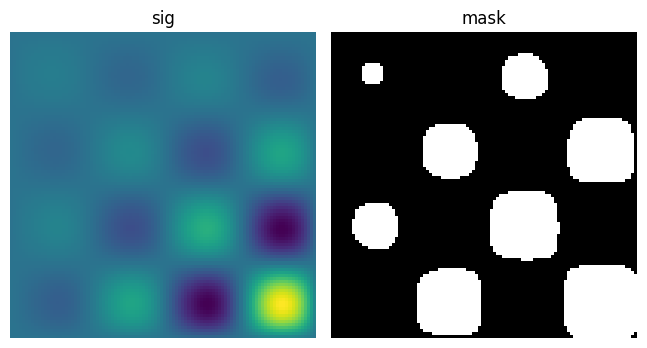

In [24]:
plt.figure(figsize=(7, 3.5))
fig, axes = plt.subplots(1, 2)
axes[0].imshow(sig)
axes[0].axis("off")
axes[0].set_title("sig")
axes[1].imshow(mask, cmap="gray")
axes[1].axis("off")
axes[1].set_title("mask")
plt.subplots_adjust(wspace=0.05, left=0.01, bottom=0.01, right=0.99, top=0.9);

{func}`scipy.ndimage.label` assigns a different label to each connected
component:

In [25]:
labels, nb = sp.ndimage.label(mask)
nb

8

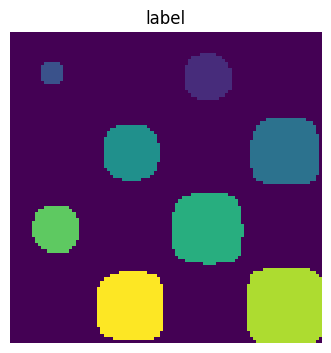

In [26]:
plt.figure(figsize=(3.5, 3.5))
plt.imshow(labels)
plt.title("label")
plt.axis("off")

plt.subplots_adjust(wspace=0.05, left=0.01, bottom=0.01, right=0.99, top=0.9)

Now compute measurements on each connected component:

In [27]:
areas = sp.ndimage.sum(mask, labels, range(1, labels.max()+1))
areas   # The number of pixels in each connected component

array([190.,  45., 424., 278., 459., 190., 549., 424.])

In [28]:
maxima = sp.ndimage.maximum(sig, labels, range(1, labels.max()+1))
maxima  # The maximum signal in each connected component

array([ 1.80238238,  1.13527605,  5.51954079,  2.49611818,  6.71673619,
        1.80238238, 16.76547217,  5.51954079])

Extract the 4th connected component, and crop the array around it:

In [29]:
sl_3 = sp.ndimage.find_objects(labels)[3]
sl_3

(slice(30, 48, None), slice(30, 48, None))

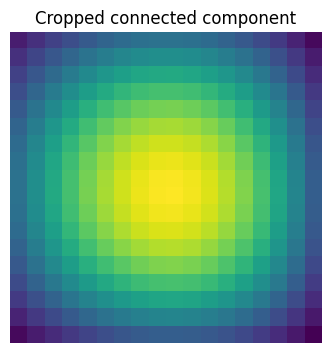

In [30]:
plt.figure(figsize=(3.5, 3.5))
plt.imshow(sig[sl_3])
plt.title("Cropped connected component")
plt.axis("off")

plt.subplots_adjust(wspace=0.05, left=0.01, bottom=0.01, right=0.99, top=0.9)

See the summary exercise on {ref}`summary-exercise-image-processing` for a more
advanced example.